# Trabajo práctico 2 - Simulación

In [ ]:
import sys
!{sys.executable} -m pip install scipy

import matplotlib.pyplot as plt
from collections import Counter
from random import random
import math
import scipy.stats as st
import numpy as np

# Procesos de Poission

## Ejercicio 1

Utilizando Matlab, Octave o Python (sin utilizar Simpy) se debe determinar con cuál de las siguientes 2 arquitecturas nos permite tener un menor tiempo de procesamiento.
A un procesador arriban instrucciones siguiendo una distribución exponencial con una tasa de 250 instrucciones por
microsegundo.
Las instrucciones se pueden agrupar en las siguientes categorías, y en función de ella es el tiempo que demoran en ser ejecutadas el cual sigue una distribución exponencial con parámetro lambda especificado a continuación.

| Tipo de instrucción | Probabilidad | Tasa del tiempo de ejecución (instrucciones por µseg) |
|:-------------------:|:------------:|:-----------------------------------------------------:|
|        Simple       |      0,6     |                           60                          |
|       Compleja      |      0,4     |                           10                          |

Se sabe que el 65% de las instrucciones requieren buscar datos en memoria para antes de ser ejecutadas.
En este punto se plantean dos alternativas: 


<table>
 <tr>
    <td style="text-align: left; width: 100px;"><b>Alternativa 1:</b></td>
    <td style="text-align: left;">Cada vez que se requiera un dato de memoria se lo busca en memoria principal. Tarea cuyo tiempo corresponde a una distribución exponencial con una tasa de 2000 instrucciones por microsegundo. </td>
 </tr>
 <tr>
    <td style="text-align: left; width: 100px;"><b>Alternativa 2:</b></td>
    <td style="text-align: left;">Implementar un Caché, con el cual existiría una probabilidad de .6 de encontrar el dato requerido y no tener la necesidad de buscarlo en memoria principal.
 El tiempo de acceso a este caché se puede modelar siguiendo una distribución exponencial con una
tasa de 500 instrucciones por microsegundo.
 Cuando el dato no es encontrado en el caché y debe buscarse en memoria principal donde su demora
también sigue una distribución exponencial con una tasa de 1500 instrucciones por microsegundo. </td>
 </tr>
</table>

El arribo de instrucciones a un procesador se pueden modelar como un proceso de Poisson debido a que los arribos siguen una distribución exponencial de 250 instrucciones/us.

Sean:

$\Pi$ = "Arribo de instrucciones a un procesador" ~ Poi($\lambda$ = 250 ins/$\mu$s)

$\Pi_{1}$ = "Arribo de una instrucción simples a un procesador" ~ Poi($\lambda_{1}$ = 0,6 * 250 ins/$\mu$s)

$\Pi_{2}$ = "Arribo de una instruccións complejas a un procesador" ~ Poi($\lambda_{2}$ = 0,4 * 250 ins/$\mu$s)

$T_{P1}$ = "Tiempo que demora una instrucción simple en ser ejecutada" ~ exp($\lambda_{P1}$ = 60 ins/$\mu$s)

$T_{P2}$ = "Tiempo que demora una instrucción compleja en ser ejecutada" ~ exp($\lambda_{P2}$ = 10 ins/$\mu$s)

$P_{M}$ = "Probabilidad de tener que buscar el dato en memoria" = 0.65

<b>Para alternativa 1</b>

$T_{1}$ = "Tiempo que demora el procesador en buscar un dato en memoria" ~ exp($\lambda_{T1}$ = 2000 ins/$\mu$s)

<b>Para alternativa 2</b>

$P_{C}$ = "Probabilidad de que el dato se encuentre en caché" = 0.6

$T_{C}$ = "Tiempo que demora el procesador en buscar el dato en caché" ~ exp($\lambda_{C}$ = 500 ins/$\mu$s)

$T_{NC}$ = "Tiempo que demora el procesador en buscar el dato en memoria y volcarlo en caché" ~ exp($\lambda_{NC}$ = 1500 ins/$\mu$s)

Para resolver el problema, se simulará una variable aleatoria uniforme para identificar si la instrucción es simple o compleja, en base a eso se generará el tiempo que demora en arribar y procesarse. Luego, se simulará otra variable aleatoria uniforme para ver si la instrucción busca datos en memoria o no. Si necesita ir a buscar datos a memoria, entonces se elegirá entre la alternativa 1 o la 2.
Cada experiencia si simulará múltiples veces para corroborar cual es la mejora alternativa en varias experiencias

In [ ]:
def inversa_exponencial(lam = 1):
    u = random()
    return (-1/lam) * math.log(1 - u)

def tiempo_de_procesamiento(ProbabilidadInstruccionSimple,
                            ProbabilidadDatoMemoria,
                            TasaArriboInstruccionSimple,
                            TasaArriboInstruccionCompleja,
                            TasaEjecucionInstruccionSimple,
                            TasaEjecucionInstruccionCompleja,
                            TasaBuscarDatosMemoriaAlternativa1,
                            ProbabilidadDatoEnCache,
                            TasaAccesoMemoriaCache,
                            TasaAccesoMemoriaNoCache,
                            alternativa = 1,
                            exp_func = inversa_exponencial):
    u_P = random() # probabilidad de que la instruccion sea simple
    if u_P < ProbabilidadInstruccionSimple: # la instruccion es simple
        Talt1 = exp_func(TasaArriboInstruccionSimple) # tiempo de arribo
        Talt1 = Talt1 + exp_func(TasaEjecucionInstruccionSimple) # tiempo en ser ejecutadas
    else:
        Talt1 = exp_func(TasaArriboInstruccionCompleja) # tiempo de arribo
        Talt1 = Talt1 + exp_func(TasaEjecucionInstruccionCompleja) # tiempo en ser ejecutadas

    u_M = random() # probabilidad de que tenga que ir a buscar datos a memoria
    if u_M < ProbabilidadDatoMemoria: # busca datos en memoria
        if alternativa == 1:
            Talt1 = Talt1 + exp_func(TasaBuscarDatosMemoriaAlternativa1) # tiempo de buscar en memoria con la alternativa 1
        else: # alternativa 2
            u_PC = random()
            if u_PC < ProbabilidadDatoEnCache: # el dato se encuentra en cache
                Talt1 = Talt1 + exp_func(TasaAccesoMemoriaCache)
            else:
                Talt1 = Talt1 + exp_func(TasaAccesoMemoriaNoCache)
                
    return Talt1
        
TasaArriboInstruccion = 250 # tasa de arribo de insutrucciones a un micro

ProbabilidadInstruccionSimple = 0.6 # probabilidad que la instruccione sea simple

TasaArriboInstruccionSimple = ProbabilidadInstruccionSimple * TasaArriboInstruccion  # tasa de arribo de una instruccion simple a un micro
TasaArriboInstruccionCompleja = (1-ProbabilidadInstruccionSimple) * TasaArriboInstruccion # tasa de arribo de una instruccion compuesta a un micro

TasaEjecucionInstruccionSimple = 60 # tasa que demora una instruccion simple en ser ejecutada
TasaEjecucionInstruccionCompleja = 10 # tasa que demora una instruccion compuesta en ser ejecutada

TasaBuscarDatosMemoriaAlternativa1 = 2000 # tasa de buscar datos en memoria con la alternativa 1

ProbabilidadDatoMemoria = 0.65 # probabilidad de tener que buscar un dato en memoria

ProbabilidadDatoEnCache = 0.6 # probabilidad de encontrar el dato requerido en memoria cache
TasaAccesoMemoriaCache = 500 # tasa de buscar datos en memoria cache con la alternativa 2
TasaAccesoMemoriaNoCache = 1500 # tasa de buscar datos en emmoria principal con la alternativa 2


n = 100
for j in range(4):
    t1 = 0
    t2 = 0
    for datos in range(n):
        # alternativa 1
        t1 = t1 + tiempo_de_procesamiento(ProbabilidadInstruccionSimple,
                                          ProbabilidadDatoMemoria,
                                          TasaArriboInstruccionSimple,
                                          TasaArriboInstruccionCompleja,
                                          TasaEjecucionInstruccionSimple,
                                          TasaEjecucionInstruccionCompleja,
                                          TasaBuscarDatosMemoriaAlternativa1,
                                          ProbabilidadDatoEnCache,
                                          TasaAccesoMemoriaCache,
                                          TasaAccesoMemoriaNoCache,
                                          1,
                                          inversa_exponencial)

        # alternativa 2
        t2 = t2 + tiempo_de_procesamiento(ProbabilidadInstruccionSimple,
                                          ProbabilidadDatoMemoria,
                                          TasaArriboInstruccionSimple,
                                          TasaArriboInstruccionCompleja,
                                          TasaEjecucionInstruccionSimple,
                                          TasaEjecucionInstruccionCompleja,
                                          TasaBuscarDatosMemoriaAlternativa1,
                                          ProbabilidadDatoEnCache,
                                          TasaAccesoMemoriaCache,
                                          TasaAccesoMemoriaNoCache,
                                          2,
                                          inversa_exponencial)
    
    print("Para ",n," datos | ","ALTERNATIVA 1 = ",t1," microseg",", ALTERNATIVA 2 = ",t2," microseg")
    n = n * 10

En la ejecución, observamos que la alternativa 1 parece ser levemente mejor que la 2. Sin embargo, no hay tanto diferencia, por lo que podemos repetir estas experiencias (por ej. para n = 1000) varias veces y contar en cuantas oportunidades t2 > t1

In [ ]:
n = 1000
count1 = count2 = 0
for count in range(10000):
    t1 = 0
    t2 = 0
    
    for datos in range(n):
        # alternativa 1
        t1 = t1 + tiempo_de_procesamiento(ProbabilidadInstruccionSimple,
                                          ProbabilidadDatoMemoria,
                                          TasaArriboInstruccionSimple,
                                          TasaArriboInstruccionCompleja,
                                          TasaEjecucionInstruccionSimple,
                                          TasaEjecucionInstruccionCompleja,
                                          TasaBuscarDatosMemoriaAlternativa1,
                                          ProbabilidadDatoEnCache,
                                          TasaAccesoMemoriaCache,
                                          TasaAccesoMemoriaNoCache,
                                          1,
                                          inversa_exponencial)

        # alternativa 2
        t2 = t2 + tiempo_de_procesamiento(ProbabilidadInstruccionSimple,
                                          ProbabilidadDatoMemoria,
                                          TasaArriboInstruccionSimple,
                                          TasaArriboInstruccionCompleja,
                                          TasaEjecucionInstruccionSimple,
                                          TasaEjecucionInstruccionCompleja,
                                          TasaBuscarDatosMemoriaAlternativa1,
                                          ProbabilidadDatoEnCache,
                                          TasaAccesoMemoriaCache,
                                          TasaAccesoMemoriaNoCache,
                                          2,
                                          inversa_exponencial)
    
    if t1 < t2:
        count1 = count1 + 1
    else:
        count2 = count2 + 1
        
if count2 > count1:
    print("La alternativa 2 demoró menos tiempo una mayor cantidad de veces que la alternativa 1")
else:
    print("La alternativa 1 demoró menos tiempo una mayor cantidad de veces que la alternativa 2")

Entonces efectivamente, cuando realizamos las las experncias y las contamos, en general la alternativa 1 demora menos

# Cadenas de Markov

## Ejercicio 2 

Una entidad bancaria se encuentra analizando cuantos clientes en simultáneo están conectados a su home banking.
Para ello comenzó a monitorear cada minuto la cantidad de clientes activos, y analizó como se modifica esta cantidad de una observación a la siguiente.
Se determinó que la probabilidad que la cantidad de clientes conectados aumentara, o se mantenga igual, podía modelarse utilizando una distribución de probabilidad Binomial, mientras que la probabilidad de tener menos clientes conectados respondía a una distribución uniforme.
Siendo i y j dos cantidades de usuarios conectados al sistema. 

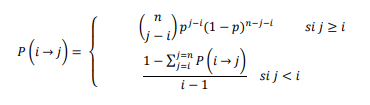

Se sabe además que la probabilidad que un cliente se conecte al sitio es p=0,7 (Por simplicidad supondremos que el servidor de este home banking permite cómo máximo 50 clientes en simultáneo) 

a) Determinar la matriz de transición de estados explicando cómo se obtiene la misma.

b) Utilizando Matlab, Octave o Python simular una posible evolución del sistema a lo largo de 100 observaciones graficando cómo se modifica la cantidad de clientes conectados en cada momento.

c) Simulando 100.000 observaciones realizar un histograma mostrando cuantas veces el sistema estuvo en cada estado. (Recomendación: utilizar tantas categorías en el histograma como estados tiene el sistema).

d) Determinar el % de tiempo que en el home banking no tuvo clientes conectados.

e) Se está evaluando migrar el home banking a un servidor que permitiría cómo máximo 40 clientes conectados en simultáneo. La migración sólo se realizaría si la probabilidad de tener más de 40 clientes es menor a 10%. Indique si se puede recomendar realizar la migración. 

### a)
Sabiendo que n = 50 es la cantidad máxima de clientes y p = 0.7 la probabilidad de conectarse al sistema, podemos calcular la matriz de transición de la siguiente manera:
* Primero calculamos las transiciones donde j >= i, es decir, 0 -> 1, 0 -> 2, ..., 0 -> 50, 1 -> 2, 1 -> 3, ..., 1 -> 50, ..., 49 -> 50, 50 -> 50
* Luego calculamos las transiciones donde j < i, es decir, 1 -> 0, 2 -> 0, 2 -> 1, ..., 50 -> 0, 50 -> 1, ..., 50 -> 49
* Con estos dos vectores, podemos armar la matriz de transición colocando los resultados en la posición (i,j)

In [ ]:
def combinatoria(m, n):
    return math.factorial(m) // (math.factorial(n) * math.factorial(m - n))

def sumatoria(matrix, begin, n):
    suma = 0
    for j in range(begin,n):
        suma = suma + matrix[begin][j]
    return suma
    
n = 50
p = 0.7
P = [[0 for i in range(n + 1)] for j in range(n + 1)]
for i in range(n + 1):
    for j in range(n + 1):
        if(j >= i): # binomial
            P[i][j] = combinatoria(n,j-i) * (p ** (j-i)) * ((1 - p) ** (n-j-i))
        else: # uniforme
            P[i][j] = (1 - sumatoria(P,i,n)) / (i) # (i - 1) TODO: PREGUNTAR!!!!

### b)

Podemos suponer que inicialmente no habia ningún cliente conectado, por lo que, P0 = [1 0 ... 0]. Si multiplicamos P0 por P, obtenemos la probabilidad del estado siguiente. Si lo repetimos 100 veces, retroalimentando nuestro sistema, podemos simular como evoluciona la cadena

In [ ]:
import matplotlib.pyplot as plt

width = 16
height = 8
plt.figure(figsize=(width, height))

P0 = [ 0 for i in range(n + 1)]
P0[0] = 1 # no hay ningun cliente al comienzo

result = []
for iexp in range(100):
    u = random()
    #Armo el vector de probabilidad acumulada
    PAcum = [P0[0]]
    for index in range(1, len(P0)):
        PAcum.append(PAcum[index - 1] + P0[index])

    i = 1
    while i < len(P0):
        if u > PAcum[i] and u < PAcum[i-1]:
            break;
        else:
            i = i + 1
        
    result.append(i-1) # guardo
    np.linalg.matrix_power(P, iexp)
    P0 = np.dot(P0, P)

plt.plot(result)
plt.ylabel('Cantidad de conectados')
plt.xlabel('Instante')
plt.show()

### c)

Vamos a aplicar la misma lógica que en el ejercicio anterior, pero esta vez contando cuantas veces hay cada cantidad de trabajadores.

In [ ]:
width = 16
height = 8
plt.figure(figsize=(width, height))

P0 = [ 0 for i in range(n + 1)]
P0[0] = 1 # no hay ningun cliente al comienzo
contador = [0 for i in range(n + 1)]

for iexp in range(1000): #TODO: Cambiar a 100000
    u = random()
    #Armo el vector de probabilidad acumulada
    PAcum = [P0[0]]
    for index in range(1, len(P0)):
        PAcum.append(PAcum[index - 1] + P0[index])
    
    i = 1
    while i < len(P0):
        if u > PAcum[i] and u < PAcum[i-1]:
            break;
        else:
            i = i + 1
        
    contador[i - 1] += 1 # guardo
    #np.linalg.matrix_power(P, iexp)
    P0 = np.dot(P0, P)
    
plt.hist(result, bins = 51)
plt.ylabel('Cantidad de repeticiones')
plt.xlabel('Cantidad de conectados')
plt.show()

In [ ]:
print(contador)

### d)

Dos formas: sacamos el porcentaje de steps que tuvieron 0 conectados en el punto c, o buscamos la matriz de convergencia para ver el % de tiempo teorico

In [ ]:
# TODO: CAMBIAR PORQUE ESTA DIVIENDO POR 1000
print("De acuerdo con la simulación del punto c, el % de tiempo que no tuvo clientes conectados fue %" + str(contador[0] / 1000))

In [ ]:
from numpy import matrix

P_asintotica = matrix(P) ** 10000
print("De acuerdo con la matriz asintotica, el % de tiempo que no tuvo clientes conectados fue %" + str(P_asintotica.tolist()[0][0] * 100))


### e)

Dos formas: sacamos el porcentaje de steps que tuvieron 41 a 50 conectados en el punto c, o buscamos la matriz de convergencia para ver la probabilidad de que haya 41 a 50 usuarios conectados

In [ ]:
cantidad_mayor_40 = 0
for i in range(41, 51):
    cantidad_mayor_40 += contador[i]

# TODO: CAMBIAR PORQUE ESTA DIVIENDO POR 1000
print("De acuerdo con la simulación del punto c, la probabilidad de que haya mas de 40 usuarios conectados en simultaneo es " + str(cantidad_mayor_40 / 1000))

In [ ]:
probabilidad_mayor_40 = 0
for i in range(41, 51):
    probabilidad_mayor_40 += P_asintotica.tolist()[0][i]

print("De acuerdo con la matriz asintotica, la probabilidad de que haya mas de 40 usuarios conectados en simultaneo es " + str(probabilidad_mayor_40))

# Simpy

## Ejercicio 4 

Resolver el Ejercicio 1 utilizando Simpy y comparar los resultados obtenidos con los obtenidos en el Ejercicio1. 

Al igual que en el ejercicio 2, miramos los tiempos de ejecucion de cada alternativa pero pasandole al calulador de tiempo alguna función que genere exponenciales de Simpy

In [ ]:
# TODO: corregir con lo que se va a ver en clase
n = 100
for j in range(4):
    t1 = 0
    t2 = 0
    for datos in range(n):
        # alternativa 1
        t1 = t1 + tiempo_de_procesamiento(ProbabilidadInstruccionSimple,
                                          ProbabilidadDatoMemoria,
                                          TasaArriboInstruccionSimple,
                                          TasaArriboInstruccionCompleja,
                                          TasaEjecucionInstruccionSimple,
                                          TasaEjecucionInstruccionCompleja,
                                          TasaBuscarDatosMemoriaAlternativa1,
                                          ProbabilidadDatoEnCache,
                                          TasaAccesoMemoriaCache,
                                          TasaAccesoMemoriaNoCache,
                                          1,
                                          inversa_exponencial)

        # alternativa 2
        t2 = t2 + tiempo_de_procesamiento(ProbabilidadInstruccionSimple,
                                          ProbabilidadDatoMemoria,
                                          TasaArriboInstruccionSimple,
                                          TasaArriboInstruccionCompleja,
                                          TasaEjecucionInstruccionSimple,
                                          TasaEjecucionInstruccionCompleja,
                                          TasaBuscarDatosMemoriaAlternativa1,
                                          ProbabilidadDatoEnCache,
                                          TasaAccesoMemoriaCache,
                                          TasaAccesoMemoriaNoCache,
                                          2,
                                          inversa_exponencial)
    
    print("Para ",n," datos | ","ALTERNATIVA 1 = ",t1," microseg",", ALTERNATIVA 2 = ",t2," microseg")
    n = n * 10